# Discretising the wave equation

We now consider the second order wave equation

$$
u_{tt} = c^2u_{xx}
$$

for $x\in [0, 1]$, $u(x, 0) = U_0(x)$, $u_t(x, 0) = 0$, $u(0, t) = 0$, $u(1, t) = 0$.

A simple finite difference scheme can be derived by using the three-point stencil in time and in space. This gives us

$$
\frac{u_i^{n+1} - 2u_{i}^n + u_i^{n-1}}{\Delta t^2} = c^2\frac{u_{i+1}^n - 2u_i^n + u_{i-1}^n}{\Delta x^2}.
$$

We hence obtain the next time-step $u_i^{n+1}$ as

$$
u_i^{n+1} = -u_i^{n-1} + 2u_i^n + C^2\left(u_{i+1}^n - 2u_i^n + u_{i-1}^n\right)
$$

with $C = c\frac{\Delta t}{\Delta x}$ being called the Courant number. This method is called the leapfrog method. In the following we will develop a graphical understanding how this method is working.

## A graphical description of the Leapfrog Method

We first define some helper functions to simply the plotting of the leap-frog scheme.

In [6]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

def circle(ax, x, y, color='b'):
    """Helper to draw a circle."""
    circle = plt.Circle((x, y), .15, color=color, fill=False, clip_on=False)
    ax.add_artist(circle)
    
def draw_leap_frog(red_circs=[], blue_circs=[], ax=None):
    """Helper to draw the leap-frog dependencies."""

    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
    ax.set_ylim(0, 10)
    ax.set_xlim(0, 10)
    ax.set_xlabel('i')
    ax.set_ylabel('n')
    ax.grid()
    ax.xaxis.set_ticks(np.arange(11))
    ax.yaxis.set_ticks(np.arange(11));
    
    for circ in red_circs:
        circle(ax, *circ, 'r')
        
    for circ in blue_circs:
        circle(ax, *circ, 'b')
    
    return ax
        
def draw_dependency_graph(x, y, ax=None):
    """Draw leap-frog dependency graph"""
    red_circ = [(x, y)]
    bounds = [x - 1, x + 1]
    blue_circs = []
    for ycoord in range(y - 1, -1, -1):
        for xcoord in range(bounds[0], bounds[1] + 1):
            blue_circs.append((xcoord, ycoord))
        bounds[0] -= 1
        bounds[1] += 1
    draw_leap_frog(red_circ, blue_circs, ax)

### The first iteration step.

In the first step we have the problem that we cannot yet fully evaluate the leap-frog formula. In order to compute $u_i^{1}$ we would need the value at $u_i^{-1}$, which doesn't exist. Here, the initial condition at the derivative comes in. The first derivative at the start should be $0$. If we use a simple central difference formula around to implement the first derivative we derive that $u_i^{-1} = u_i^{1}$, giving us the required value.

Below the current value $u_i^{1}$ is shown with a red circle and the values it depends on, are shown with a blue circle.

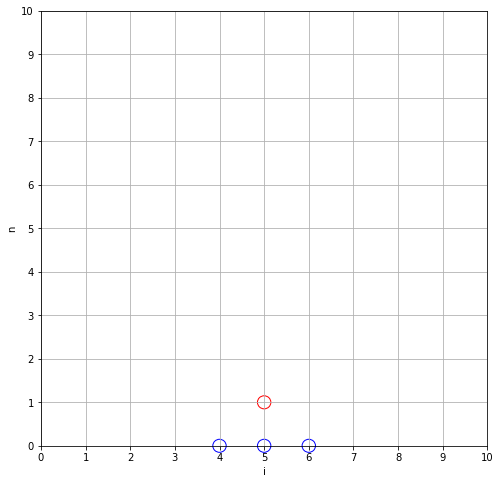

In [7]:
draw_dependency_graph(5, 1);

## The following iterations

We now proceed with the iteration. The current value is always shown with a red circle and the chain of values that contributed to the value are shown with blue circles. The following shows the dependent values for a point at time-steps 2 to 5.

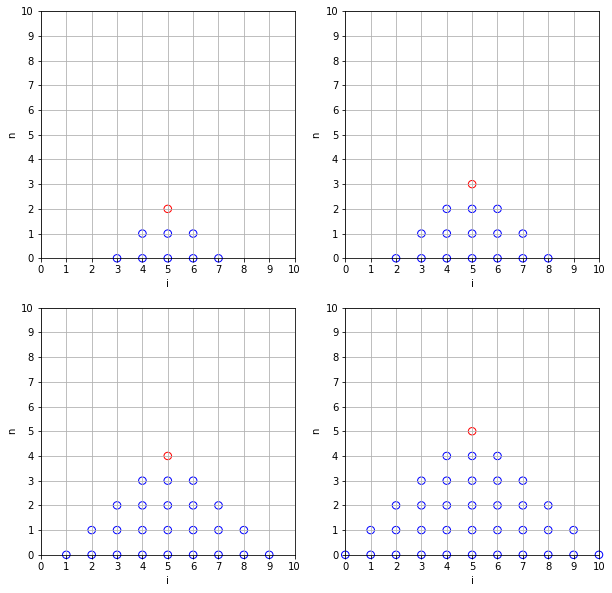

In [8]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
draw_dependency_graph(5, 2, ax1)
draw_dependency_graph(5, 3, ax2)
draw_dependency_graph(5, 4, ax3)
draw_dependency_graph(5, 5, ax4)

We see that a dependency cone is forming. In the following we discuss this in more detail.

## The dependence cone of the wave equation

Any twice differentiable function $F$ gives us two solutions of the wave equation, namely $u_1(x, t) = F(x - ct)$ and $u_2(x, t) = F(x + ct)$. The lines $x-ct = \text{const}$ and $x+ct = \text{const}$ are characteristics. They describe how information is transported from the origin with $t=0$ to other time-steps.

If we want to satisfy the initial conditions $u(x, 0) = U_0(x)$ and $U_t(x, 0) = 0$ we can choose the solution

$$
u(x, t) = \frac{1}{2}\left[U_0(x - ct) + U_0(x + ct)\right].
$$

This solution does not necessarily satisfy our boundary conditions $u(0, t) = u(1, t) = 0$. But for the sake of simplicity we ignore this here. We see that at a given point $(x, t)$ the solution depends on the values of $U_0$ at $x - ct$ and $x + ct$. This is due to the nature of the wave equation. We have a finite speed of propagation of information $c$ and this is reflected in the solution.

The numerical leap-frog scheme recreates this dependency cone. However, we require that the numerical dependency cone is at least as large as the physical dependency cone. If this is not the case we are losing out physical information and our solution becomes meaningless. Hence, we require that

$$
c\leq \frac{\Delta x}{\Delta t},
$$

where on the right-hand side we have the numerical speed of propagation.

This is equivalent to the condition that

$$
C := c\frac{\Delta t}{\Delta x} \leq 1.
$$

This condition is also called **Courant-Friedrichs-Lewy (CFL)** condition and guarantees that our solution remains numerically bounded.

If we are in the limit case $C=1$ then the current value $u_i^n$ cancels out of our recurrence formua. We are leaping over it to obtain the new value. If $C < 1$ then we have that 

$$
u_i^{n+1} = 2(1 - C^2)u_i^n + \dots.
$$

Hence, the influence of $u_i^{n}$ becomes quadratically smaller as $C\rightarrow 1$.

## Numerical implementation of the Leapfrog Scheme.

We want to implement a finite difference method for the wave equation $u_{tt} = c^2u_{xx}$ for $c=1$ and $(x, 0) \in [0, 1]\times [0, 2]$. The initial condition is $u(x, 0) = e^{-5(x-.5)^2}$ and the boundary conditions are $\frac{\partial}{\partial n} u = 0$ otherwise (Here, $n$ is the normal derivative along the normal direction of the boundary). We are going to use the leapfrog scheme. At the boundary $x=0$ we use a centered difference to obtain the condition that the required value at $u_{-1}^n$ is just $u_1^n$ (with the corresponding condition at the other boundary).

Courant Number: 0.995
Elapsed time (s): 0.20034098625183105


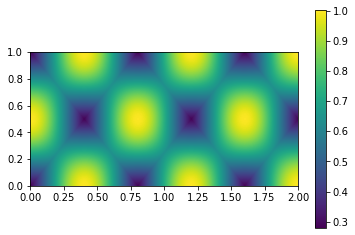

In [4]:
def solve_wave_equation(N, time_steps, c=1, T=1):
    """
    Solves a 1d wave equation.

    This function solves the 1d wave equation
    with zero boundary conditions. The x-domain is the
    interval [0, 1] and the final time is T.
    """

    xt_grid = np.zeros((N, time_steps + 1), dtype='float64')
    xx = np.linspace(0, 1, N)

    # Set initial condition
    xt_grid[:, 0] = np.exp(-5 * (xx-.5)**2)

    dt = T / (1.0 * time_steps)
    dx = 1. / (N - 1)

    # Compute courant number
    C = c * dt / dx
    print("Courant Number: {0}".format(C))

    # Set first step

    for index in range(0, N):
        il = 1 if index == 0 else index - 1
        ir = N - 2 if index == N - 1 else index + 1
        xt_grid[index, 1] = xt_grid[index, 0] - \
            .5 * C**2 * (xt_grid[ir, 0] - 2 * xt_grid[index, 0]
                + xt_grid[il, 0])

    # Compute the other steps

    for t_index in range(1, time_steps ):
        for x_index in range(0, N):
            il = 1 if x_index == 0 else x_index - 1
            ir = N - 2 if x_index == N - 1 else x_index + 1
            xt_grid[x_index, t_index + 1] = \
                (- xt_grid[x_index, t_index - 1] + 2 * xt_grid[x_index, t_index] +
                 C**2 * (xt_grid[ir, t_index] -
                 2 * xt_grid[x_index, t_index] +
                 xt_grid[il, t_index]))

    return xt_grid

from time import time

T = 2
st = time()
res = solve_wave_equation(200, 500, c=1./0.8, T=T)
et = time()
print("Elapsed time (s): {0}".format(et - st))

plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()


In the above example the Courant number is almost $1$. Yet, the scheme is perfectly stable. Let us consider what happens if $C > 1$.

Courant Number: 1.0348000000000002
Elapsed time (s): 0.18599629402160645


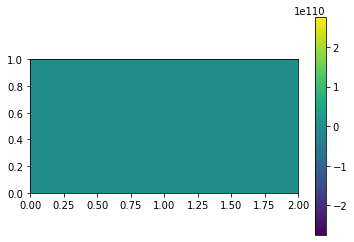

In [5]:
T = 2
st = time()
res = solve_wave_equation(200, 500, c=1.3, T=T)
et = time()
print("Elapsed time (s): {0}".format(et - st))

plt.imshow(res, extent=[0, T, 0, 1])
plt.colorbar()
plt.show()


Now we have chosen $c$ such that the Courant number is just above $1$ and the solution completely explodes. This is a beautiful example for how stability is derived from proper physical considerations in the implementation of a numerical scheme.

## A final remark

We have presented here a method for directly discretising the second order wave equation. One can also reformulate the wave equation as a first-order equation and then apply all the methods well known for first-order problems. Which method is applied in practice depends on the application and what information is needed. If in addition to $u$ also the time-derivative $u_t$ is required at each step, then a first-order method is often more useful. For a simple direct discretisation of the wave equation leapfrog is a very simple and effective scheme.